# 📊 Análisis de Sentimientos - Amazon Reviews en Español

Este notebook implementa un **pipeline completo de Machine Learning** para clasificación de sentimientos en reseñas de Amazon en español.

## 🎯 Objetivo del Proyecto

Crear una API que recibe textos (comentarios, reseñas) y devuelve:
- **Clasificación de sentimiento**: Positivo, Neutro o Negativo
- **Probabilidad** asociada a la predicción

## 📁 Dataset

- **Fuente**: `test.csv` - Reseñas multilingües de Amazon
- **Filtro**: `language='es'` (español)
- **Registros**: ~5000 opiniones en español
- **Columnas principales**: `review_body`, `stars`, `product_category`

## 🔄 Pipeline del Proyecto

| Paso | Descripción |
|------|-------------|
| 1 | **Carga de Datos** - Filtrar reseñas en español |
| 2 | **EDA** - Análisis exploratorio de datos |
| 3 | **Preprocesamiento** - Limpieza y normalización de texto |
| 4 | **Vectorización TF-IDF** - Transformar texto en números |
| 5 | **Entrenamiento** - Logistic Regression multiclase |
| 6 | **Evaluación** - Métricas de rendimiento |
| 7 | **Serialización** - Guardar modelo para producción |
| 8 | **API REST** - FastAPI para predicciones |

## 📋 Clasificación de Sentimientos

| Estrellas | Sentimiento |
|-----------|-------------|
| ⭐⭐⭐⭐⭐ (5) y ⭐⭐⭐⭐ (4) | **Positivo** |
| ⭐⭐⭐ (3) | **Neutro** |
| ⭐⭐ (2) y ⭐ (1) | **Negativo** |

---

## 1. Importar Librerías

Importamos todas las librerías necesarias para el proyecto:
- **pandas/numpy**: Manipulación de datos
- **matplotlib/seaborn**: Visualizaciones
- **sklearn**: Machine Learning (TF-IDF, Logistic Regression, métricas)
- **nltk**: Procesamiento de lenguaje natural (stopwords, stemming)
- **joblib**: Serialización del modelo

In [1]:
# =============================================================================
# IMPORTACIÓN DE LIBRERÍAS
# =============================================================================

# Manipulación de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    classification_report,
    confusion_matrix
)

# Procesamiento de Lenguaje Natural
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Serialización
import joblib

# Utilidades
import os
import re
import time
import warnings

# Configuración global
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Descargar recursos de NLTK necesarios
print("📥 Descargando recursos de NLTK...")
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
print("✅ Librerías importadas y configuradas correctamente")

📥 Descargando recursos de NLTK...
✅ Librerías importadas y configuradas correctamente


## 2. Cargar y Filtrar Dataset

Cargamos el archivo `test.csv` que contiene reseñas multilingües de Amazon y filtramos únicamente las reseñas en **español** (`language='es'`).

### Estructura esperada del dataset:
- `review_id`: Identificador único de la reseña
- `product_id`: Identificador del producto
- `reviewer_id`: Identificador del revisor
- `stars`: Calificación (1-5 estrellas)
- `review_body`: Texto de la reseña
- `review_title`: Título de la reseña
- `language`: Idioma de la reseña
- `product_category`: Categoría del producto

In [2]:
# =============================================================================
# CARGA Y FILTRADO DEL DATASET
# =============================================================================

print("=" * 80)
print("CARGA DEL DATASET")
print("=" * 80)

# Cargar el dataset completo
df_raw = pd.read_csv('test.csv')

print(f"\n📊 Dataset original:")
print(f"   • Registros totales: {len(df_raw):,}")
print(f"   • Columnas: {len(df_raw.columns)}")
print(f"\n📋 Columnas disponibles:")
for i, col in enumerate(df_raw.columns, 1):
    print(f"   {i}. {col}")

# Mostrar distribución de idiomas
print(f"\n🌐 Distribución de idiomas:")
print(df_raw['language'].value_counts())

# Filtrar solo reseñas en español
df = df_raw[df_raw['language'] == 'es'].copy()
df = df.reset_index(drop=True)

print(f"\n" + "=" * 80)
print("DATASET FILTRADO - ESPAÑOL")
print("=" * 80)
print(f"\n✅ Reseñas en español: {len(df):,}")
print(f"   • Porcentaje del total: {len(df)/len(df_raw)*100:.1f}%")

# Mostrar primeras filas
print(f"\n📝 Primeras reseñas:")
df[['stars', 'review_title', 'review_body', 'product_category']].head()

CARGA DEL DATASET

📊 Dataset original:
   • Registros totales: 30,000
   • Columnas: 9

📋 Columnas disponibles:
   1. Unnamed: 0
   2. review_id
   3. product_id
   4. reviewer_id
   5. stars
   6. review_body
   7. review_title
   8. language
   9. product_category

🌐 Distribución de idiomas:
language
de    5000
en    5000
es    5000
fr    5000
ja    5000
zh    5000
Name: count, dtype: int64

DATASET FILTRADO - ESPAÑOL

✅ Reseñas en español: 5,000
   • Porcentaje del total: 16.7%

📝 Primeras reseñas:


,stars,review_title,review_body,product_category
0,1,no me llego,no me llego el articulo me lo mando por correo...,wireless
1,1,amazon sigue sin cumplir en las entregas,"la mensajería horrible, no compro mas",home
2,1,ESTAFA EN EL ENVÍO,Estoy muy decepcionado con el vendedor ya que ...,toy
3,1,Estafa de Amazon,Mi valoración no es sobre el producto sino sob...,home
4,1,No conseguí pasar de la portada en Kindle,Pues tenía interés en este libro y probé la ve...,digital_ebook_purchase


In [3]:
# =============================================================================
# CREAR COLUMNA DE SENTIMIENTO Y CONFIDENCE SCORE BASADO EN ESTRELLAS
# =============================================================================

print("=" * 80)
print("HOMOLOGACIÓN: ESTRELLAS ↔ CONFIDENCE SCORE ↔ SENTIMIENTO")
print("=" * 80)

# =============================================================================
# FUNCIONES DE CONVERSIÓN
# =============================================================================

def stars_to_confidence(stars):
    """
    Convierte calificación de estrellas a confidence score normalizado.
    
    Mapeo:
    - 5 estrellas → 0.90 (rango 0.80-1.00)
    - 4 estrellas → 0.70 (rango 0.60-0.79)
    - 3 estrellas → 0.50 (rango 0.40-0.59)
    - 2 estrellas → 0.30 (rango 0.20-0.39)
    - 1 estrella  → 0.10 (rango 0.00-0.19)
    
    Args:
        stars: Número de estrellas (1-5)
    
    Returns:
        float: Confidence score (0.0 - 1.0)
    """
    mapping = {
        5: 0.90,
        4: 0.70,
        3: 0.50,
        2: 0.30,
        1: 0.10
    }
    return mapping.get(int(stars), 0.50)

def confidence_to_stars(confidence):
    """
    Convierte confidence score a calificación de estrellas.
    
    Rangos:
    - 0.80-1.00 → 5 estrellas
    - 0.60-0.79 → 4 estrellas
    - 0.40-0.59 → 3 estrellas
    - 0.20-0.39 → 2 estrellas
    - 0.00-0.19 → 1 estrella
    
    Args:
        confidence: Confidence score (0.0 - 1.0)
    
    Returns:
        int: Número de estrellas (1-5)
    """
    if confidence >= 0.80:
        return 5
    elif confidence >= 0.60:
        return 4
    elif confidence >= 0.40:
        return 3
    elif confidence >= 0.20:
        return 2
    else:
        return 1

def confidence_to_sentiment(confidence):
    """
    Convierte confidence score a sentimiento.
    
    Rangos:
    - 0.60-1.00 → Positivo
    - 0.40-0.59 → Neutro
    - 0.00-0.39 → Negativo
    
    Args:
        confidence: Confidence score (0.0 - 1.0)
    
    Returns:
        str: 'Positivo', 'Neutro', o 'Negativo'
    """
    if confidence >= 0.60:
        return 'Positivo'
    elif confidence >= 0.40:
        return 'Neutro'
    else:
        return 'Negativo'

def stars_to_sentiment(stars):
    """
    Convierte estrellas directamente a sentimiento.
    
    Args:
        stars: Número de estrellas (1-5)
    
    Returns:
        str: 'Positivo', 'Neutro', o 'Negativo'
    """
    if stars >= 4:
        return 'Positivo'
    elif stars == 3:
        return 'Neutro'
    else:
        return 'Negativo'

# Mostrar tabla de homologación
print("""
╔═══════════════════════════════════════════════════════════════════════╗
║              TABLA DE HOMOLOGACIÓN                                    ║
╠═══════════════════════════════════════════════════════════════════════╣
║  Estrellas  │  Confidence Score  │  Rango         │  Sentimiento      ║
╠═══════════════════════════════════════════════════════════════════════╣
║  ⭐⭐⭐⭐⭐ (5)  │      0.90          │  0.80 - 1.00   │  ✅ Positivo      ║
║  ⭐⭐⭐⭐ (4)   │      0.70          │  0.60 - 0.79   │  ✅ Positivo      ║
║  ⭐⭐⭐ (3)    │      0.50          │  0.40 - 0.59   │  ⚪ Neutro        ║
║  ⭐⭐ (2)     │      0.30          │  0.20 - 0.39   │  ❌ Negativo      ║
║  ⭐ (1)      │      0.10          │  0.00 - 0.19   │  ❌ Negativo      ║
╚═══════════════════════════════════════════════════════════════════════╝
""")

# Aplicar las funciones para crear las columnas
df['Sentiment'] = df['stars'].apply(stars_to_sentiment)
df['confidence_score'] = df['stars'].apply(stars_to_confidence)

# Mostrar distribución de sentimientos
print("📊 Distribución de Sentimientos:")
sentiment_counts = df['Sentiment'].value_counts()
sentiment_pct = df['Sentiment'].value_counts(normalize=True) * 100

for sentiment in ['Positivo', 'Neutro', 'Negativo']:
    count = sentiment_counts.get(sentiment, 0)
    pct = sentiment_pct.get(sentiment, 0)
    emoji = "✅" if sentiment == 'Positivo' else "⚪" if sentiment == 'Neutro' else "❌"
    print(f"   {emoji} {sentiment}: {count:,} ({pct:.1f}%)")

# Mostrar estadísticas de confidence score
print(f"\n📊 Estadísticas de Confidence Score:")
print(f"   • Promedio: {df['confidence_score'].mean():.2f}")
print(f"   • Mínimo: {df['confidence_score'].min():.2f}")
print(f"   • Máximo: {df['confidence_score'].max():.2f}")

print(f"\n✅ Columnas 'Sentiment' y 'confidence_score' creadas exitosamente")

HOMOLOGACIÓN: ESTRELLAS ↔ CONFIDENCE SCORE ↔ SENTIMIENTO

╔═══════════════════════════════════════════════════════════════════════╗
║              TABLA DE HOMOLOGACIÓN                                    ║
╠═══════════════════════════════════════════════════════════════════════╣
║  Estrellas  │  Confidence Score  │  Rango         │  Sentimiento      ║
╠═══════════════════════════════════════════════════════════════════════╣
║  ⭐⭐⭐⭐⭐ (5)  │      0.90          │  0.80 - 1.00   │  ✅ Positivo      ║
║  ⭐⭐⭐⭐ (4)   │      0.70          │  0.60 - 0.79   │  ✅ Positivo      ║
║  ⭐⭐⭐ (3)    │      0.50          │  0.40 - 0.59   │  ⚪ Neutro        ║
║  ⭐⭐ (2)     │      0.30          │  0.20 - 0.39   │  ❌ Negativo      ║
║  ⭐ (1)      │      0.10          │  0.00 - 0.19   │  ❌ Negativo      ║
╚═══════════════════════════════════════════════════════════════════════╝

📊 Distribución de Sentimientos:
   ✅ Positivo: 2,000 (40.0%)
   ⚪ Neutro: 1,000 (20.0%)
   ❌ Negativo: 2,000 (40.0%)

📊 Estadísticas

## 3. Análisis Exploratorio de Datos (EDA)

Realizamos un análisis exhaustivo del dataset para entender su estructura, identificar patrones y detectar posibles problemas en los datos.

In [4]:
# =============================================================================
# INFORMACIÓN GENERAL DEL DATASET
# =============================================================================

print("=" * 80)
print("INFORMACIÓN GENERAL DEL DATASET")
print("=" * 80)

print(f"\n📐 Dimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")

print("\n" + "-" * 40)
print("TIPOS DE DATOS")
print("-" * 40)
print(df.dtypes)

print("\n" + "-" * 40)
print("INFORMACIÓN DETALLADA")
print("-" * 40)
df.info()

INFORMACIÓN GENERAL DEL DATASET

📐 Dimensiones: 5,000 filas × 11 columnas

----------------------------------------
TIPOS DE DATOS
----------------------------------------
Unnamed: 0            int64
review_id            object
product_id           object
reviewer_id          object
stars                 int64
review_body          object
review_title         object
language             object
product_category     object
Sentiment            object
confidence_score    float64
dtype: object

----------------------------------------
INFORMACIÓN DETALLADA
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        5000 non-null   int64  
 1   review_id         5000 non-null   object 
 2   product_id        5000 non-null   object 
 3   reviewer_id       5000 non-null   object 
 4   stars  

## 4. Análisis de Calidad de Datos

Verificamos la calidad de los datos: valores nulos, duplicados y otras anomalías.

In [5]:
# =============================================================================
# ANÁLISIS DE VALORES NULOS Y DUPLICADOS
# =============================================================================

print("=" * 80)
print("ANÁLISIS DE CALIDAD DE DATOS")
print("=" * 80)

# Valores nulos
print("\n📊 VALORES NULOS:")
print("-" * 40)
null_counts = df.isnull().sum()
null_pct = (df.isnull().sum() / len(df)) * 100

null_analysis = pd.DataFrame({
    'Columna': null_counts.index,
    'Nulos': null_counts.values,
    'Porcentaje': null_pct.values
})
null_analysis = null_analysis[null_analysis['Nulos'] > 0]

if len(null_analysis) > 0:
    print(null_analysis.to_string(index=False))
else:
    print("   ✅ No hay valores nulos en el dataset")

# Duplicados
print("\n📊 DUPLICADOS:")
print("-" * 40)
duplicates = df.duplicated().sum()
dup_review = df.duplicated(subset=['review_body']).sum()

print(f"   • Filas duplicadas (exactas): {duplicates:,}")
print(f"   • Reseñas duplicadas (review_body): {dup_review:,}")

if duplicates > 0:
    print(f"   ⚠️ Se encontraron {duplicates} duplicados")
else:
    print("   ✅ No hay duplicados exactos")

# Estadísticas de estrellas
print("\n📊 DISTRIBUCIÓN DE ESTRELLAS:")
print("-" * 40)
stars_dist = df['stars'].value_counts().sort_index()
for stars, count in stars_dist.items():
    bar = "⭐" * int(stars)
    print(f"   {bar} ({stars}): {count:,} ({count/len(df)*100:.1f}%)")

ANÁLISIS DE CALIDAD DE DATOS

📊 VALORES NULOS:
----------------------------------------
   ✅ No hay valores nulos en el dataset

📊 DUPLICADOS:
----------------------------------------
   • Filas duplicadas (exactas): 0
   • Reseñas duplicadas (review_body): 6
   ✅ No hay duplicados exactos

📊 DISTRIBUCIÓN DE ESTRELLAS:
----------------------------------------
   ⭐ (1): 1,000 (20.0%)
   ⭐⭐ (2): 1,000 (20.0%)
   ⭐⭐⭐ (3): 1,000 (20.0%)
   ⭐⭐⭐⭐ (4): 1,000 (20.0%)
   ⭐⭐⭐⭐⭐ (5): 1,000 (20.0%)


In [6]:
# =============================================================================
# ANÁLISIS POR CATEGORÍA DE PRODUCTO
# =============================================================================

print("=" * 80)
print("ANÁLISIS POR CATEGORÍA DE PRODUCTO")
print("=" * 80)

# Distribución de categorías
category_counts = df['product_category'].value_counts()
print(f"\n📦 Total de categorías: {df['product_category'].nunique()}")
print(f"\n📊 Top 10 categorías:")
print("-" * 40)

for i, (category, count) in enumerate(category_counts.head(10).items(), 1):
    print(f"   {i:2d}. {category:25s}: {count:,} ({count/len(df)*100:.1f}%)")

# Sentimientos por categoría (top 5 categorías)
print("\n" + "=" * 80)
print("SENTIMIENTOS POR CATEGORÍA (Top 5)")
print("=" * 80)

top_categories = category_counts.head(5).index.tolist()
sentiment_by_category = pd.crosstab(
    df[df['product_category'].isin(top_categories)]['product_category'],
    df[df['product_category'].isin(top_categories)]['Sentiment'],
    normalize='index'
) * 100

print(sentiment_by_category.round(1).to_string())

ANÁLISIS POR CATEGORÍA DE PRODUCTO

📦 Total de categorías: 30

📊 Top 10 categorías:
----------------------------------------
    1. home                     : 707 (14.1%)
    2. wireless                 : 650 (13.0%)
    3. toy                      : 349 (7.0%)
    4. sports                   : 336 (6.7%)
    5. home_improvement         : 290 (5.8%)
    6. electronics              : 263 (5.3%)
    7. pc                       : 256 (5.1%)
    8. automotive               : 179 (3.6%)
    9. kitchen                  : 177 (3.5%)
   10. beauty                   : 175 (3.5%)

SENTIMIENTOS POR CATEGORÍA (Top 5)
Sentiment         Negativo  Neutro  Positivo
product_category                            
home                  36.1    21.4      42.6
home_improvement      40.3    19.3      40.3
sports                44.6    15.2      40.2
toy                   37.5    24.9      37.5
wireless              47.8    18.3      33.8


## 5. Visualización de Distribución de Sentimientos

Creamos gráficos para visualizar la distribución de sentimientos en el dataset.

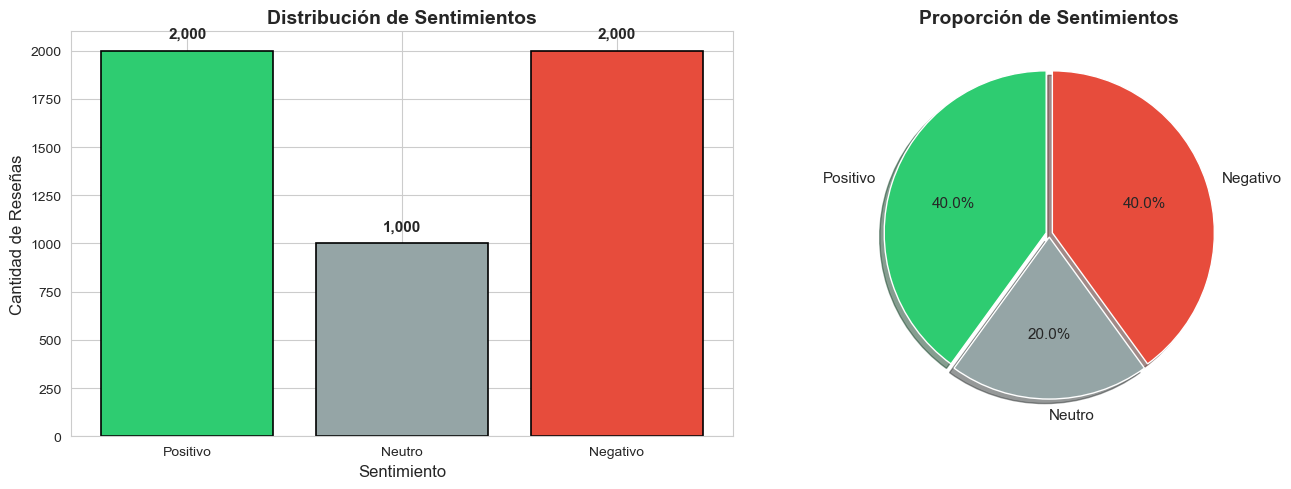

📊 Resumen de distribución:
   • Positivo: 2,000 reseñas (40.0%)
   • Neutro: 1,000 reseñas (20.0%)
   • Negativo: 2,000 reseñas (40.0%)


In [7]:
# =============================================================================
# VISUALIZACIÓN DE DISTRIBUCIÓN DE SENTIMIENTOS
# =============================================================================

# Definir colores para cada sentimiento
colors = {'Positivo': '#2ecc71', 'Neutro': '#95a5a6', 'Negativo': '#e74c3c'}
sentiment_order = ['Positivo', 'Neutro', 'Negativo']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
sentiment_counts_ordered = df['Sentiment'].value_counts()[sentiment_order]
bars = axes[0].bar(sentiment_order, sentiment_counts_ordered.values, 
                   color=[colors[s] for s in sentiment_order], edgecolor='black', linewidth=1.2)
axes[0].set_title('Distribución de Sentimientos', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sentimiento', fontsize=12)
axes[0].set_ylabel('Cantidad de Reseñas', fontsize=12)

# Añadir etiquetas en las barras
for bar, count in zip(bars, sentiment_counts_ordered.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                 f'{count:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Gráfico de pastel
axes[1].pie(sentiment_counts_ordered.values, 
            labels=sentiment_order, 
            autopct='%1.1f%%',
            colors=[colors[s] for s in sentiment_order],
            startangle=90,
            explode=(0.02, 0.02, 0.02),
            shadow=True,
            textprops={'fontsize': 11})
axes[1].set_title('Proporción de Sentimientos', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("📊 Resumen de distribución:")
for sentiment in sentiment_order:
    count = sentiment_counts_ordered[sentiment]
    pct = count / len(df) * 100
    print(f"   • {sentiment}: {count:,} reseñas ({pct:.1f}%)")

## 6. Análisis de Longitud de Texto

Analizamos la longitud de las reseñas (caracteres y palabras) para entender las características del texto.

In [8]:
# =============================================================================
# ANÁLISIS DE LONGITUD DE TEXTO
# =============================================================================

# Calcular estadísticas de longitud
df['text_length'] = df['review_body'].astype(str).str.len()
df['word_count'] = df['review_body'].astype(str).str.split().str.len()

print("=" * 80)
print("ESTADÍSTICAS DE LONGITUD DE TEXTO")
print("=" * 80)

print("\n📏 LONGITUD EN CARACTERES:")
print("-" * 40)
print(f"   • Promedio: {df['text_length'].mean():.1f} caracteres")
print(f"   • Mediana:  {df['text_length'].median():.1f} caracteres")
print(f"   • Mínimo:   {df['text_length'].min()} caracteres")
print(f"   • Máximo:   {df['text_length'].max():,} caracteres")
print(f"   • Desv. Std: {df['text_length'].std():.1f}")

print("\n📝 CANTIDAD DE PALABRAS:")
print("-" * 40)
print(f"   • Promedio: {df['word_count'].mean():.1f} palabras")
print(f"   • Mediana:  {df['word_count'].median():.1f} palabras")
print(f"   • Mínimo:   {df['word_count'].min()} palabras")
print(f"   • Máximo:   {df['word_count'].max():,} palabras")

# Textos muy cortos
short_texts = df[df['text_length'] < 10]
print(f"\n⚠️ Textos muy cortos (<10 caracteres): {len(short_texts)} ({len(short_texts)/len(df)*100:.2f}%)")

ESTADÍSTICAS DE LONGITUD DE TEXTO

📏 LONGITUD EN CARACTERES:
----------------------------------------
   • Promedio: 151.9 caracteres
   • Mediana:  122.0 caracteres
   • Mínimo:   20 caracteres
   • Máximo:   1,789 caracteres
   • Desv. Std: 132.5

📝 CANTIDAD DE PALABRAS:
----------------------------------------
   • Promedio: 27.9 palabras
   • Mediana:  22.0 palabras
   • Mínimo:   2 palabras
   • Máximo:   366 palabras

⚠️ Textos muy cortos (<10 caracteres): 0 (0.00%)


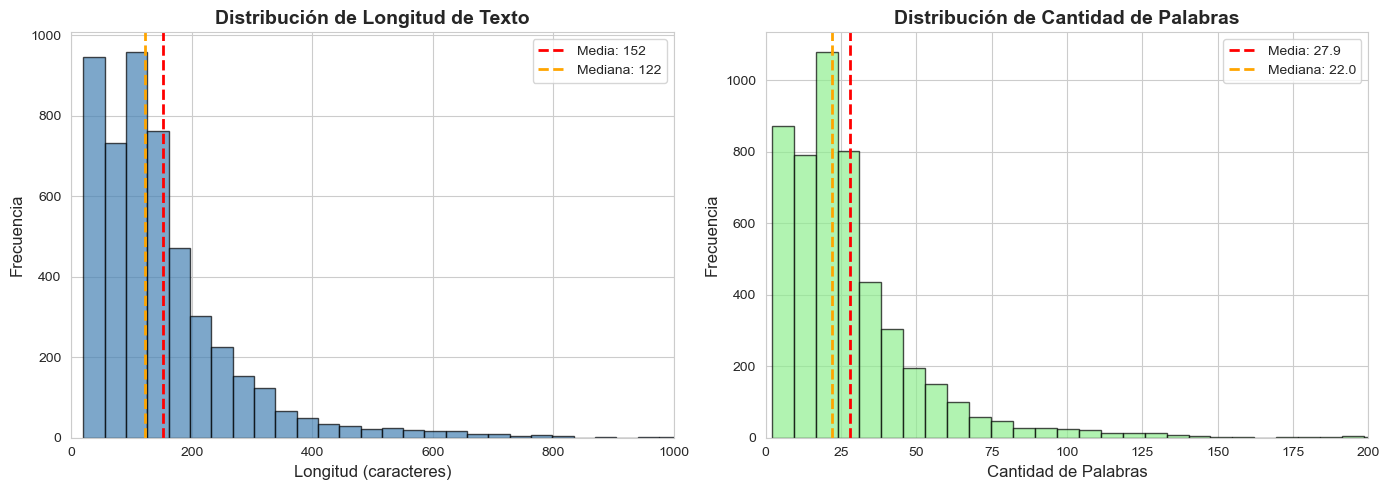

In [9]:
# =============================================================================
# VISUALIZACIÓN DE DISTRIBUCIÓN DE LONGITUD
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma de longitud de texto
axes[0].hist(df['text_length'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(df['text_length'].mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Media: {df["text_length"].mean():.0f}')
axes[0].axvline(df['text_length'].median(), color='orange', linestyle='--', linewidth=2,
                label=f'Mediana: {df["text_length"].median():.0f}')
axes[0].set_title('Distribución de Longitud de Texto', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Longitud (caracteres)', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].legend()
axes[0].set_xlim(0, 1000)  # Limitar para mejor visualización

# Histograma de conteo de palabras
axes[1].hist(df['word_count'], bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1].axvline(df['word_count'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Media: {df["word_count"].mean():.1f}')
axes[1].axvline(df['word_count'].median(), color='orange', linestyle='--', linewidth=2,
                label=f'Mediana: {df["word_count"].median():.1f}')
axes[1].set_title('Distribución de Cantidad de Palabras', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Cantidad de Palabras', fontsize=12)
axes[1].set_ylabel('Frecuencia', fontsize=12)
axes[1].legend()
axes[1].set_xlim(0, 200)  # Limitar para mejor visualización

plt.tight_layout()
plt.show()

---

# 🔄 SECCIÓN 2: PREPROCESAMIENTO Y ENTRENAMIENTO DEL MODELO

## 7. Preprocesamiento de Texto para NLP

Definimos la función de preprocesamiento que incluye:
1. Conversión a minúsculas
2. Eliminación de URLs, menciones y hashtags
3. Eliminación de caracteres especiales y números
4. Eliminación de stopwords en español
5. Aplicación de stemming con SnowballStemmer

In [10]:
# =============================================================================
# CONFIGURACIÓN DE HERRAMIENTAS DE NLP
# =============================================================================

# Configurar stemmer para español
stemmer = SnowballStemmer('spanish')

# Stopwords en español (NLTK + personalizadas)
stop_words_es = set(stopwords.words('spanish'))

# Agregar stopwords adicionales comunes en reseñas
stop_words_adicionales = {
    '', 'si', 'no', 'más', 'ya', 'muy', 'solo', 'así', 'aunque', 'tan',
    'amazon', 'producto', 'compra', 'artículo', 'envío', 'llegó', 'llegado',
    'día', 'días', 'bien', 'mal', 'cosa', 'cosas', 'vez', 'veces'
}
stop_words_es.update(stop_words_adicionales)

print(f"✅ Stemmer configurado: SnowballStemmer (español)")
print(f"✅ Stopwords cargadas: {len(stop_words_es)} palabras")

✅ Stemmer configurado: SnowballStemmer (español)
✅ Stopwords cargadas: 334 palabras


In [11]:
# =============================================================================
# FUNCIÓN DE PREPROCESAMIENTO DE TEXTO
# =============================================================================

def preprocess_text(text):
    """
    Preprocesa texto en español para análisis de sentimientos.
    
    Pipeline de preprocesamiento:
    1. Convertir a minúsculas
    2. Eliminar URLs (http, https, www)
    3. Eliminar menciones (@usuario)
    4. Eliminar hashtags (#tema)
    5. Eliminar emojis y caracteres especiales Unicode
    6. Eliminar números
    7. Eliminar espacios múltiples
    8. Tokenizar el texto
    9. Eliminar stopwords y palabras muy cortas
    10. Aplicar stemming (reducir palabras a su raíz)
    
    Args:
        text (str): Texto original a preprocesar
        
    Returns:
        str: Texto preprocesado y limpio
    """
    # Verificar que el texto no sea nulo o vacío
    if not text or pd.isna(text):
        return ""
    
    # Paso 1: Convertir a string y minúsculas
    text = str(text).lower()
    
    # Paso 2: Eliminar URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Paso 3: Eliminar menciones (@usuario)
    text = re.sub(r'@\w+', '', text)
    
    # Paso 4: Eliminar hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Paso 5: Eliminar emojis y caracteres especiales Unicode
    # Mantener solo letras, espacios y caracteres especiales del español
    text = re.sub(r'[^\w\sáéíóúüñ¡¿]', '', text)
    
    # Paso 6: Eliminar números
    text = re.sub(r'\d+', '', text)
    
    # Paso 7: Eliminar espacios múltiples y limpiar
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Paso 8: Tokenizar
    tokens = text.split()
    
    # Pasos 9-10: Eliminar stopwords, palabras cortas y aplicar stemming
    tokens = [
        stemmer.stem(word) 
        for word in tokens 
        if word not in stop_words_es and len(word) > 2
    ]
    
    return ' '.join(tokens)

# Demostración del preprocesamiento
print("=" * 80)
print("DEMOSTRACIÓN DE PREPROCESAMIENTO")
print("=" * 80)

ejemplos = [
    "¡Me encanta este producto! Es increíble 😍 https://amazon.com @usuario",
    "Muy decepcionado, no funciona bien. 2 estrellas máximo.",
    "El producto está OK, cumple su función básica."
]

for i, texto in enumerate(ejemplos, 1):
    procesado = preprocess_text(texto)
    print(f"\n{i}. Original:  \"{texto}\"")
    print(f"   Procesado: \"{procesado}\"")

print("\n✅ Función de preprocesamiento definida correctamente")

DEMOSTRACIÓN DE PREPROCESAMIENTO

1. Original:  "¡Me encanta este producto! Es increíble 😍 https://amazon.com @usuario"
   Procesado: "¡me encant increibl"

2. Original:  "Muy decepcionado, no funciona bien. 2 estrellas máximo."
   Procesado: "decepcion funcion estrell maxim"

3. Original:  "El producto está OK, cumple su función básica."
   Procesado: "cumpl funcion basic"

✅ Función de preprocesamiento definida correctamente


## 8. Aplicar Preprocesamiento al Dataset

Aplicamos la función de preprocesamiento a todas las reseñas del dataset.

In [12]:
# =============================================================================
# APLICAR PREPROCESAMIENTO AL DATASET
# =============================================================================

print("=" * 80)
print("PREPROCESAMIENTO DE TEXTOS")
print("=" * 80)
print("⏳ Procesando textos... esto puede tomar unos segundos\n")

start_time = time.time()

# Aplicar preprocesamiento a la columna review_body
df['text_processed'] = df['review_body'].apply(preprocess_text)

processing_time = time.time() - start_time

# Estadísticas del preprocesamiento
print(f"✅ Preprocesamiento completado en {processing_time:.2f} segundos")
print(f"\n📊 Estadísticas:")
print(f"   • Textos procesados: {len(df):,}")
print(f"   • Longitud promedio original: {df['review_body'].astype(str).str.len().mean():.1f} caracteres")
print(f"   • Longitud promedio procesado: {df['text_processed'].str.len().mean():.1f} caracteres")

# Textos vacíos después del preprocesamiento
empty_processed = df[df['text_processed'].str.strip() == '']
print(f"   • Textos vacíos después del preprocesamiento: {len(empty_processed)}")

# Mostrar ejemplos
print("\n" + "=" * 80)
print("EJEMPLOS DE PREPROCESAMIENTO")
print("=" * 80)

sample_indices = df.sample(5, random_state=42).index
for i, idx in enumerate(sample_indices, 1):
    original = df.loc[idx, 'review_body']
    procesado = df.loc[idx, 'text_processed']
    sentiment = df.loc[idx, 'Sentiment']
    
    # Truncar si es muy largo
    original_display = original[:80] + "..." if len(str(original)) > 80 else original
    
    print(f"\n{i}. [{sentiment}]")
    print(f"   Original:  \"{original_display}\"")
    print(f"   Procesado: \"{procesado}\"")

PREPROCESAMIENTO DE TEXTOS
⏳ Procesando textos... esto puede tomar unos segundos

✅ Preprocesamiento completado en 1.72 segundos

📊 Estadísticas:
   • Textos procesados: 5,000
   • Longitud promedio original: 151.9 caracteres
   • Longitud promedio procesado: 72.6 caracteres
   • Textos vacíos después del preprocesamiento: 2

EJEMPLOS DE PREPROCESAMIENTO

1. [Negativo]
   Original:  "Las bolsas que se venden de 120 litros, que se suponen que van bien al cubo. Ni ..."
   Procesado: "bols vend litr supon van cub asom boc cub grand bols cub correct preci bols carisim sirv"

2. [Neutro]
   Original:  "Dicen claramente en la oferta que son dos unidades. A mi me han traído una. Si s..."
   Procesado: "dic clar ofert dos unidad traid sol envi deb rectific ofert"

3. [Neutro]
   Original:  "Traía 2 protectores en un sobre de carta postal. Podrían asegurarlos más porque ..."
   Procesado: "tra protector cart postal podr asegur podr romp med exact preci siend dos"

4. [Negativo]
   Original:  "D

## 9. Preparación de Datos para Entrenamiento

Preparamos los datos eliminando registros con textos vacíos y separando features (X) y target (y).

In [13]:
# =============================================================================
# PREPARACIÓN DE DATOS PARA ENTRENAMIENTO
# =============================================================================

print("=" * 80)
print("PREPARACIÓN DE DATOS")
print("=" * 80)

# Crear copia limpia del dataset
df_clean = df.copy()

# Eliminar filas con textos vacíos después del preprocesamiento
df_clean = df_clean[df_clean['text_processed'].str.strip() != '']
df_clean = df_clean.dropna(subset=['text_processed', 'Sentiment'])
df_clean = df_clean.reset_index(drop=True)

print(f"\n📊 Registros después de limpieza: {len(df_clean):,}")
print(f"   • Eliminados: {len(df) - len(df_clean):,}")

# Separar features (X) y target (y)
X = df_clean['text_processed']
y = df_clean['Sentiment']

print(f"\n📊 Distribución de clases:")
for sentiment in ['Positivo', 'Neutro', 'Negativo']:
    count = (y == sentiment).sum()
    pct = count / len(y) * 100
    print(f"   • {sentiment}: {count:,} ({pct:.1f}%)")

PREPARACIÓN DE DATOS

📊 Registros después de limpieza: 4,998
   • Eliminados: 2

📊 Distribución de clases:
   • Positivo: 2,000 (40.0%)
   • Neutro: 999 (20.0%)
   • Negativo: 1,999 (40.0%)


## 10. División Train/Test

Dividimos los datos en conjuntos de entrenamiento (80%) y prueba (20%) usando muestreo estratificado para mantener la proporción de clases.

In [14]:
# =============================================================================
# DIVISIÓN TRAIN/TEST
# =============================================================================

print("=" * 80)
print("DIVISIÓN DE DATOS: ENTRENAMIENTO / PRUEBA")
print("=" * 80)

# División estratificada 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,          # 20% para prueba
    random_state=42,        # Reproducibilidad
    stratify=y              # Mantener proporción de clases
)

print(f"\n📊 División completada:")
print(f"   ┌─────────────────────────────────────────┐")
print(f"   │ Conjunto        │ Muestras  │ Porcentaje │")
print(f"   ├─────────────────────────────────────────┤")
print(f"   │ Entrenamiento   │ {len(X_train):>8,} │    80%     │")
print(f"   │ Prueba          │ {len(X_test):>8,} │    20%     │")
print(f"   └─────────────────────────────────────────┘")

print(f"\n📊 Distribución en entrenamiento:")
for sentiment in ['Positivo', 'Neutro', 'Negativo']:
    count = (y_train == sentiment).sum()
    print(f"   • {sentiment}: {count:,} ({count/len(y_train)*100:.1f}%)")

print(f"\n📊 Distribución en prueba:")
for sentiment in ['Positivo', 'Neutro', 'Negativo']:
    count = (y_test == sentiment).sum()
    print(f"   • {sentiment}: {count:,} ({count/len(y_test)*100:.1f}%)")

DIVISIÓN DE DATOS: ENTRENAMIENTO / PRUEBA

📊 División completada:
   ┌─────────────────────────────────────────┐
   │ Conjunto        │ Muestras  │ Porcentaje │
   ├─────────────────────────────────────────┤
   │ Entrenamiento   │    3,998 │    80%     │
   │ Prueba          │    1,000 │    20%     │
   └─────────────────────────────────────────┘

📊 Distribución en entrenamiento:
   • Positivo: 1,600 (40.0%)
   • Neutro: 799 (20.0%)
   • Negativo: 1,599 (40.0%)

📊 Distribución en prueba:
   • Positivo: 400 (40.0%)
   • Neutro: 200 (20.0%)
   • Negativo: 400 (40.0%)


## 11. Vectorización TF-IDF

**TF-IDF (Term Frequency - Inverse Document Frequency)** convierte textos en vectores numéricos:
- **TF (Term Frequency)**: Frecuencia de una palabra en un documento
- **IDF (Inverse Document Frequency)**: Importancia de una palabra en todo el corpus

Palabras frecuentes en un documento pero raras en el corpus tienen mayor peso.

In [15]:
# =============================================================================
# VECTORIZACIÓN TF-IDF
# =============================================================================

print("=" * 80)
print("VECTORIZACIÓN TF-IDF")
print("=" * 80)

# Configurar el vectorizador TF-IDF con parámetros optimizados
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,      # Máximo de 5000 features (vocabulario)
    min_df=2,               # Palabra debe aparecer en al menos 2 documentos
    max_df=0.95,            # Ignorar palabras que aparecen en >95% de documentos
    ngram_range=(1, 2),     # Unigramas y bigramas
    sublinear_tf=True       # Aplicar escala logarítmica a TF
)

print("\n⚙️ Configuración del vectorizador:")
print(f"   • max_features: 5,000 (vocabulario máximo)")
print(f"   • min_df: 2 (mínimo de documentos)")
print(f"   • max_df: 0.95 (máximo 95% de documentos)")
print(f"   • ngram_range: (1, 2) (unigramas y bigramas)")
print(f"   • sublinear_tf: True (escala logarítmica)")

# Ajustar en datos de entrenamiento y transformar
print("\n⏳ Ajustando vectorizador...")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Solo transformar datos de prueba (no ajustar)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"\n✅ Vectorización completada")
print(f"\n📊 Resultados:")
print(f"   • Vocabulario generado: {len(tfidf_vectorizer.vocabulary_):,} términos")
print(f"   • Matriz de entrenamiento: {X_train_tfidf.shape}")
print(f"   • Matriz de prueba: {X_test_tfidf.shape}")

# Mostrar algunos términos del vocabulario
print(f"\n📝 Muestra del vocabulario (primeros 20 términos):")
vocab_sample = list(tfidf_vectorizer.vocabulary_.keys())[:20]
for i, term in enumerate(vocab_sample, 1):
    print(f"   {i:2d}. '{term}'")

VECTORIZACIÓN TF-IDF

⚙️ Configuración del vectorizador:
   • max_features: 5,000 (vocabulario máximo)
   • min_df: 2 (mínimo de documentos)
   • max_df: 0.95 (máximo 95% de documentos)
   • ngram_range: (1, 2) (unigramas y bigramas)
   • sublinear_tf: True (escala logarítmica)

⏳ Ajustando vectorizador...

✅ Vectorización completada

📊 Resultados:
   • Vocabulario generado: 5,000 términos
   • Matriz de entrenamiento: (3998, 5000)
   • Matriz de prueba: (1000, 5000)

📝 Muestra del vocabulario (primeros 20 términos):
    1. 'qued'
    2. 'parec'
    3. 'plastic'
    4. 'sup'
    5. 'funcional'
    6. 'tap'
    7. 'hac'
    8. 'rosc'
    9. 'tal'
   10. 'describ'
   11. 'apertur'
   12. 'rap'
   13. 'bastant'
   14. 'satisfech'
   15. 'tiemp'
   16. 'descrit'
   17. 'compr'
   18. 'dud'
   19. 'tal describ'
   20. 'bastant satisfech'


## 12. Entrenamiento del Modelo - Logistic Regression

**Logistic Regression** es ideal para clasificación de texto porque:
- Funciona bien con datos de alta dimensionalidad (como TF-IDF)
- Es interpretable (podemos ver qué palabras influyen más)
- Es eficiente computacionalmente
- Proporciona probabilidades de predicción
- Soporta clasificación multiclase (Positivo, Neutro, Negativo)

In [16]:
# =============================================================================
# ENTRENAMIENTO DEL MODELO - LOGISTIC REGRESSION
# =============================================================================

print("=" * 80)
print("ENTRENAMIENTO DEL MODELO")
print("=" * 80)

# Configurar el modelo de Logistic Regression
modelo_lr = LogisticRegression(
    max_iter=1000,              # Máximo de iteraciones para convergencia
    C=1.0,                      # Fuerza de regularización
    class_weight='balanced',    # Balancear clases desiguales
    random_state=42,            # Reproducibilidad
    solver='lbfgs',             # Algoritmo de optimización
    multi_class='multinomial',  # Clasificación multiclase
    n_jobs=-1                   # Usar todos los núcleos disponibles
)

print("\n⚙️ Configuración del modelo:")
print(f"   • Algoritmo: Logistic Regression")
print(f"   • Solver: lbfgs")
print(f"   • Multiclase: multinomial")
print(f"   • Class weight: balanced")
print(f"   • Max iterations: 1,000")
print(f"   • Regularización (C): 1.0")

# Entrenar el modelo
print("\n⏳ Entrenando modelo...")
start_time = time.time()

modelo_lr.fit(X_train_tfidf, y_train)

training_time = time.time() - start_time

print(f"\n✅ Modelo entrenado exitosamente")
print(f"\n📊 Información del modelo:")
print(f"   • Tiempo de entrenamiento: {training_time:.2f} segundos")
print(f"   • Clases detectadas: {modelo_lr.classes_.tolist()}")
print(f"   • Número de features: {X_train_tfidf.shape[1]:,}")
print(f"   • Iteraciones hasta convergencia: {modelo_lr.n_iter_[0]}")

ENTRENAMIENTO DEL MODELO

⚙️ Configuración del modelo:
   • Algoritmo: Logistic Regression
   • Solver: lbfgs
   • Multiclase: multinomial
   • Class weight: balanced
   • Max iterations: 1,000
   • Regularización (C): 1.0

⏳ Entrenando modelo...

✅ Modelo entrenado exitosamente

📊 Información del modelo:
   • Tiempo de entrenamiento: 1.35 segundos
   • Clases detectadas: ['Negativo', 'Neutro', 'Positivo']
   • Número de features: 5,000
   • Iteraciones hasta convergencia: 39


## 13. Evaluación del Modelo

Evaluamos el modelo usando métricas estándar de clasificación:
- **Accuracy**: Proporción de predicciones correctas
- **Precision**: De los predichos como X, cuántos realmente son X
- **Recall**: De los que son X, cuántos se predijeron como X
- **F1-Score**: Media armónica de Precision y Recall

In [17]:
# =============================================================================
# EVALUACIÓN DEL MODELO - MÉTRICAS
# =============================================================================

# Realizar predicciones en el conjunto de prueba
y_pred = modelo_lr.predict(X_test_tfidf)
y_pred_proba = modelo_lr.predict_proba(X_test_tfidf)

print("=" * 80)
print("MÉTRICAS DE EVALUACIÓN DEL MODELO")
print("=" * 80)

# Calcular métricas principales
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"""
   ╔═══════════════════════════════════════════╗
   ║        MÉTRICAS GENERALES                 ║
   ╠═══════════════════════════════════════════╣
   ║  📊 Accuracy:   {accuracy:.4f}  ({accuracy*100:.2f}%)        ║
   ║  🎯 Precision:  {precision:.4f}  ({precision*100:.2f}%)        ║
   ║  📈 Recall:     {recall:.4f}  ({recall*100:.2f}%)        ║
   ║  ⭐ F1-Score:   {f1:.4f}  ({f1*100:.2f}%)        ║
   ╚═══════════════════════════════════════════╝
""")

# Reporte detallado por clase
print("=" * 80)
print("REPORTE DE CLASIFICACIÓN DETALLADO")
print("=" * 80)
print(classification_report(y_test, y_pred, target_names=['Negativo', 'Neutro', 'Positivo']))

MÉTRICAS DE EVALUACIÓN DEL MODELO

   ╔═══════════════════════════════════════════╗
   ║        MÉTRICAS GENERALES                 ║
   ╠═══════════════════════════════════════════╣
   ║  📊 Accuracy:   0.6050  (60.50%)        ║
   ║  🎯 Precision:  0.6284  (62.84%)        ║
   ║  📈 Recall:     0.6050  (60.50%)        ║
   ║  ⭐ F1-Score:   0.6145  (61.45%)        ║
   ╚═══════════════════════════════════════════╝

REPORTE DE CLASIFICACIÓN DETALLADO
              precision    recall  f1-score   support

    Negativo       0.67      0.67      0.67       400
      Neutro       0.30      0.38      0.34       200
    Positivo       0.75      0.66      0.70       400

    accuracy                           0.60      1000
   macro avg       0.57      0.57      0.57      1000
weighted avg       0.63      0.60      0.61      1000



## 14. Matriz de Confusión

La matriz de confusión muestra cómo el modelo clasifica cada tipo de sentimiento, identificando aciertos y errores.

MATRIZ DE CONFUSIÓN


MATRIZ DE CONFUSIÓN


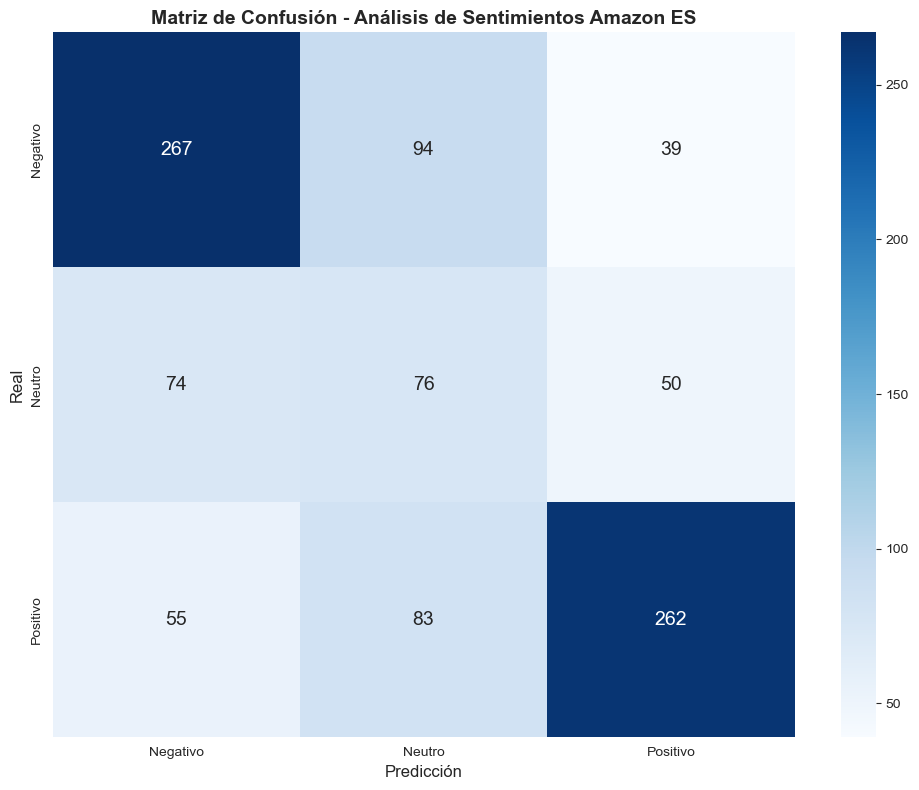


📝 Interpretación de la Matriz de Confusión:
   ✅ 267 textos 'Negativo' clasificados correctamente
   ❌ 94 textos 'Negativo' clasificados como 'Neutro'
   ❌ 39 textos 'Negativo' clasificados como 'Positivo'
   ❌ 74 textos 'Neutro' clasificados como 'Negativo'
   ✅ 76 textos 'Neutro' clasificados correctamente
   ❌ 50 textos 'Neutro' clasificados como 'Positivo'
   ❌ 55 textos 'Positivo' clasificados como 'Negativo'
   ❌ 83 textos 'Positivo' clasificados como 'Neutro'
   ✅ 262 textos 'Positivo' clasificados correctamente


In [18]:
# =============================================================================
# MATRIZ DE CONFUSIÓN
# =============================================================================

print("=" * 80)
print("MATRIZ DE CONFUSIÓN")
print("=" * 80)

# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=['Negativo', 'Neutro', 'Positivo'])

# Visualizar
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Negativo', 'Neutro', 'Positivo'],
    yticklabels=['Negativo', 'Neutro', 'Positivo'],
    annot_kws={'size': 14}
)
plt.title('Matriz de Confusión - Análisis de Sentimientos Amazon ES', 
          fontsize=14, fontweight='bold')
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.tight_layout()
plt.show()

# Interpretación
print("\n📝 Interpretación de la Matriz de Confusión:")
labels = ['Negativo', 'Neutro', 'Positivo']
for i, label_real in enumerate(labels):
    for j, label_pred in enumerate(labels):
        count = cm[i, j]
        if i == j:
            print(f"   ✅ {count:,} textos '{label_real}' clasificados correctamente")
        elif count > 0:
            print(f"   ❌ {count:,} textos '{label_real}' clasificados como '{label_pred}'")

## 15. Análisis de Importancia de Features (Explicabilidad)

Identificamos las palabras más influyentes para cada categoría de sentimiento.

In [19]:
# =============================================================================
# PALABRAS MÁS INFLUYENTES POR SENTIMIENTO
# =============================================================================

print("=" * 80)
print("PALABRAS MÁS INFLUYENTES POR SENTIMIENTO (Explicabilidad)")
print("=" * 80)

# Obtener nombres de features
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

# Para cada clase, mostrar las palabras más influyentes
labels = ['Negativo', 'Neutro', 'Positivo']

for i, label in enumerate(labels):
    # Obtener coeficientes para esta clase
    coefs = modelo_lr.coef_[i]
    
    # Top 15 palabras más influyentes (coeficientes más altos)
    top_indices = np.argsort(coefs)[-15:][::-1]
    top_features = feature_names[top_indices]
    top_values = coefs[top_indices]
    
    # Emoji según sentimiento
    emoji = "❌" if label == 'Negativo' else "⚪" if label == 'Neutro' else "✅"
    
    print(f"\n{emoji} {label.upper()}:")
    print("-" * 50)
    for feat, val in zip(top_features, top_values):
        bar = "█" * int(abs(val) * 15)
        print(f"   {feat:25s} {val:+.4f} {bar}")

PALABRAS MÁS INFLUYENTES POR SENTIMIENTO (Explicabilidad)

❌ NEGATIVO:
--------------------------------------------------
   decepcion                 +2.1513 ████████████████████████████████
   devolv                    +1.9920 █████████████████████████████
   devuelt                   +1.7842 ██████████████████████████
   recib                     +1.7349 ██████████████████████████
   recom                     +1.6867 █████████████████████████
   diner                     +1.6548 ████████████████████████
   mes                       +1.5810 ███████████████████████
   mal                       +1.5167 ██████████████████████
   dej funcion               +1.4748 ██████████████████████
   mal calid                 +1.4080 █████████████████████
   compr                     +1.3929 ████████████████████
   nunc                      +1.3591 ████████████████████
   dej                       +1.3190 ███████████████████
   malisim                   +1.2756 ███████████████████
   pesim          

---

# 💾 SECCIÓN 3: SERIALIZACIÓN Y API

## 16. Serialización del Modelo (Guardar para Producción)

Guardamos el modelo entrenado, el vectorizador TF-IDF y la configuración para uso en producción.

In [20]:
# =============================================================================
# SERIALIZACIÓN DEL MODELO
# =============================================================================

print("=" * 80)
print("SERIALIZACIÓN DEL MODELO")
print("=" * 80)

# Crear directorio para modelos si no existe
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)

# 1. Guardar el vectorizador TF-IDF
vectorizer_path = os.path.join(model_dir, 'tfidf_vectorizer.joblib')
joblib.dump(tfidf_vectorizer, vectorizer_path)
print(f"\n✅ Vectorizador guardado: {vectorizer_path}")

# 2. Guardar el modelo entrenado
model_path = os.path.join(model_dir, 'sentiment_model.joblib')
joblib.dump(modelo_lr, model_path)
print(f"✅ Modelo guardado: {model_path}")

# 3. Guardar configuración y métricas
config = {
    'classes': modelo_lr.classes_.tolist(),
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'n_features': X_train_tfidf.shape[1],
    'train_samples': len(X_train),
    'test_samples': len(X_test),
    'dataset': 'Amazon Reviews ES',
    'model_type': 'LogisticRegression',
    'vectorizer_type': 'TfidfVectorizer'
}
config_path = os.path.join(model_dir, 'model_config.joblib')
joblib.dump(config, config_path)
print(f"✅ Configuración guardada: {config_path}")

# 4. Guardar configuración de preprocesamiento
preprocess_config = {
    'stop_words': list(stop_words_es),
    'stemmer_language': 'spanish'
}
preprocess_path = os.path.join(model_dir, 'preprocess_config.joblib')
joblib.dump(preprocess_config, preprocess_path)
print(f"✅ Config. preprocesamiento guardada: {preprocess_path}")

# Verificar archivos guardados
print("\n" + "-" * 40)
print("📁 Archivos guardados en './models/':")
print("-" * 40)
for file in os.listdir(model_dir):
    path = os.path.join(model_dir, file)
    size_kb = os.path.getsize(path) / 1024
    print(f"   • {file}: {size_kb:.2f} KB")

SERIALIZACIÓN DEL MODELO

✅ Vectorizador guardado: models\tfidf_vectorizer.joblib
✅ Modelo guardado: models\sentiment_model.joblib
✅ Configuración guardada: models\model_config.joblib
✅ Config. preprocesamiento guardada: models\preprocess_config.joblib

----------------------------------------
📁 Archivos guardados en './models/':
----------------------------------------
   • model_config.joblib: 0.40 KB
   • preprocess_config.joblib: 2.96 KB
   • sentiment_model.joblib: 118.28 KB
   • tfidf_vectorizer.joblib: 168.00 KB


## 17. Función de Predicción

Definimos una función completa que preprocesa el texto, lo vectoriza y realiza la predicción.

In [21]:
# =============================================================================
# FUNCIÓN DE PREDICCIÓN COMPLETA CON HOMOLOGACIÓN
# =============================================================================

def predict_sentiment(text, vectorizer, model):
    """
    Predice el sentimiento de un texto en español.
    
    Esta función realiza el pipeline completo:
    1. Preprocesa el texto (limpieza, stopwords, stemming)
    2. Vectoriza con TF-IDF
    3. Predice la clase con el modelo
    4. Calcula probabilidades para cada clase
    5. Calcula confidence score y estrellas equivalentes
    
    Args:
        text (str): Texto a analizar
        vectorizer: TfidfVectorizer entrenado
        model: Modelo de clasificación entrenado
        
    Returns:
        dict: Diccionario con predicción, probabilidad, estrellas y confidence score
    """
    # Preprocesar el texto
    processed_text = preprocess_text(text)
    
    # Verificar que el texto procesado no esté vacío
    if not processed_text.strip():
        return {
            "prevision": "Indeterminado",
            "probabilidad": 0.0,
            "confidence_score": 0.0,
            "estrellas": 0,
            "texto_procesado": "",
            "todas_probabilidades": {},
            "error": "Texto insuficiente después del preprocesamiento"
        }
    
    # Vectorizar el texto
    text_vectorized = vectorizer.transform([processed_text])
    
    # Realizar predicción
    prediction = model.predict(text_vectorized)[0]
    probabilities = model.predict_proba(text_vectorized)[0]
    
    # Obtener todas las probabilidades por clase
    proba_dict = {cls: prob for cls, prob in zip(model.classes_, probabilities)}
    
    # Calcular confidence score ponderado basado en las probabilidades
    # Positivo tiene peso alto, Neutro peso medio, Negativo peso bajo
    prob_positivo = proba_dict.get('Positivo', 0)
    prob_neutro = proba_dict.get('Neutro', 0)
    prob_negativo = proba_dict.get('Negativo', 0)
    
    # Fórmula: Confidence Score = (P_positivo * 1.0) + (P_neutro * 0.5) + (P_negativo * 0.0)
    # Esto da un score entre 0 y 1, donde:
    # - Alto (>0.6) = Positivo
    # - Medio (0.4-0.6) = Neutro  
    # - Bajo (<0.4) = Negativo
    confidence_score = (prob_positivo * 1.0) + (prob_neutro * 0.5) + (prob_negativo * 0.0)
    confidence_score = round(confidence_score, 4)
    
    # Convertir confidence score a estrellas
    estrellas = confidence_to_stars(confidence_score)
    
    # Obtener probabilidad de la clase predicha
    class_idx = list(model.classes_).index(prediction)
    probability = probabilities[class_idx]
    
    return {
        "prevision": prediction,
        "probabilidad": round(float(probability), 4),
        "confidence_score": confidence_score,
        "estrellas": estrellas,
        "texto_procesado": processed_text,
        "todas_probabilidades": {
            cls: round(float(prob), 4) 
            for cls, prob in zip(model.classes_, probabilities)
        }
    }

print("✅ Función de predicción con homologación definida correctamente")
print("""
📋 La función ahora devuelve:
   • prevision: Sentimiento (Positivo/Neutro/Negativo)
   • probabilidad: Probabilidad de la predicción
   • confidence_score: Score normalizado (0.0-1.0)
   • estrellas: Equivalente en estrellas (1-5)
""")

✅ Función de predicción con homologación definida correctamente

📋 La función ahora devuelve:
   • prevision: Sentimiento (Positivo/Neutro/Negativo)
   • probabilidad: Probabilidad de la predicción
   • confidence_score: Score normalizado (0.0-1.0)
   • estrellas: Equivalente en estrellas (1-5)



## 18. Pruebas de Predicción

Probamos el modelo con ejemplos reales de reseñas positivas, negativas y neutras.

In [22]:
# =============================================================================
# PRUEBAS DE PREDICCIÓN CON HOMOLOGACIÓN COMPLETA
# =============================================================================

print("=" * 80)
print("🧪 PRUEBAS DE PREDICCIÓN CON SISTEMA HOMOLOGADO")
print("=" * 80)

# Ejemplos de prueba representativos
ejemplos = [
    # Positivos
    "¡Excelente producto! Superó todas mis expectativas, lo recomiendo totalmente.",
    "La calidad es increíble, llegó antes de tiempo y funciona perfectamente.",
    "Muy satisfecho con la compra, el mejor producto que he adquirido.",
    
    # Negativos
    "Muy decepcionado, no funciona como se describe. Pésima calidad.",
    "El producto llegó roto y el vendedor no responde. No lo recomiendo.",
    "Un desastre total, dinero tirado a la basura. Horrible experiencia.",
    
    # Neutros
    "El producto está bien, cumple su función básica pero nada especial.",
    "Llegó a tiempo, la calidad es aceptable por el precio.",
    "Normal, ni bueno ni malo, simplemente funciona."
]

print("\n📋 Sistema de homologación activo:")
print("   • Sentimiento: Positivo / Neutro / Negativo")
print("   • Estrellas: ⭐⭐⭐⭐⭐ (1-5)")
print("   • Confidence Score: 0.00 - 1.00")
print("\n" + "━" * 80)

for i, texto in enumerate(ejemplos, 1):
    resultado = predict_sentiment(texto, tfidf_vectorizer, modelo_lr)
    
    # Emoji y color según predicción
    if resultado['prevision'] == 'Positivo':
        emoji = "✅"
        color = "🟢"
    elif resultado['prevision'] == 'Negativo':
        emoji = "❌"
        color = "🔴"
    else:
        emoji = "⚪"
        color = "🟡"
    
    # Generar estrellas visuales
    stars_filled = "⭐" * resultado['estrellas']
    stars_empty = "☆" * (5 - resultado['estrellas'])
    stars_display = stars_filled + stars_empty
    
    # Truncar texto si es muy largo
    texto_display = texto[:60] + "..." if len(texto) > 60 else texto
    
    print(f"\n{i:2d}. \"{texto_display}\"")
    print(f"    {color} Sentimiento: {resultado['prevision']}")
    print(f"    {stars_display} ({resultado['estrellas']}/5 estrellas)")
    print(f"    📊 Confidence Score: {resultado['confidence_score']:.2%}")
    print(f"    📈 Probabilidad clase: {resultado['probabilidad']:.1%}")
    print(f"    🔍 Desglose: ", end="")
    for cls, prob in resultado['todas_probabilidades'].items():
        print(f"{cls[:3]}:{prob:.0%} ", end="")
    print()

print("\n" + "━" * 80)

# Resumen de predicciones
print("\n📊 RESUMEN DE PREDICCIONES:")
print("-" * 40)
predicciones = [predict_sentiment(t, tfidf_vectorizer, modelo_lr) for t in ejemplos]
sentimientos = [p['prevision'] for p in predicciones]
print(f"   ✅ Positivos: {sentimientos.count('Positivo')}")
print(f"   🟡 Neutros:   {sentimientos.count('Neutro')}")
print(f"   ❌ Negativos: {sentimientos.count('Negativo')}")
print(f"\n   Promedio Confidence Score: {sum(p['confidence_score'] for p in predicciones)/len(predicciones):.2%}")
print(f"   Promedio Estrellas: {sum(p['estrellas'] for p in predicciones)/len(predicciones):.1f} ⭐")

print("\n✅ Pruebas completadas exitosamente")

🧪 PRUEBAS DE PREDICCIÓN CON SISTEMA HOMOLOGADO

📋 Sistema de homologación activo:
   • Sentimiento: Positivo / Neutro / Negativo
   • Estrellas: ⭐⭐⭐⭐⭐ (1-5)
   • Confidence Score: 0.00 - 1.00

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

 1. "¡Excelente producto! Superó todas mis expectativas, lo recom..."
    🟢 Sentimiento: Positivo
    ⭐⭐⭐⭐☆ (4/5 estrellas)
    📊 Confidence Score: 79.16%
    📈 Probabilidad clase: 76.8%
    🔍 Desglose: Neg:18% Neu:5% Pos:77% 

 2. "La calidad es increíble, llegó antes de tiempo y funciona pe..."
    🟢 Sentimiento: Positivo
    ⭐⭐⭐⭐⭐ (5/5 estrellas)
    📊 Confidence Score: 84.58%
    📈 Probabilidad clase: 77.4%
    🔍 Desglose: Neg:8% Neu:14% Pos:77% 

 3. "Muy satisfecho con la compra, el mejor producto que he adqui..."
    🟢 Sentimiento: Positivo
    ⭐⭐⭐⭐☆ (4/5 estrellas)
    📊 Confidence Score: 78.20%
    📈 Probabilidad clase: 68.4%
    🔍 Desglose: Neg:12% Neu:20% Pos:68% 

 4. "Muy decepcionado, no funciona como 

## 19. Crear API REST con FastAPI

Generamos el código de la API REST que expone el modelo para predicciones en producción.

In [23]:
# =============================================================================
# CREAR API REST CON FASTAPI (CON HOMOLOGACIÓN)
# =============================================================================

api_code = '''"""
SentimentAPI - API de Análisis de Sentimientos en Español
=========================================================

API REST para clasificación de sentimientos en reseñas de Amazon en español.
Clasificaciones: Positivo, Neutro, Negativo

Sistema Homologado:
- Sentimiento: Positivo / Neutro / Negativo
- Estrellas: 1-5 ⭐
- Confidence Score: 0.0-1.0

Ejecutar con: uvicorn main:app --reload --port 8000
Documentación: http://localhost:8000/docs
"""

from fastapi import FastAPI, HTTPException
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel, Field, validator
import joblib
import re
import os
from typing import Optional, Dict
from datetime import datetime
import logging

# Configuración de logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# =============================================================================
# CONFIGURACIÓN DE LA API
# =============================================================================

app = FastAPI(
    title="SentimentAPI - Amazon ES",
    description="API de Análisis de Sentimientos para reseñas de Amazon en español (Sistema Homologado)",
    version="2.0.0",
    docs_url="/docs",
    redoc_url="/redoc"
)

# Configurar CORS para permitir peticiones desde cualquier origen
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

# =============================================================================
# RUTAS DE ARCHIVOS DEL MODELO
# =============================================================================

MODEL_DIR = os.path.join(os.path.dirname(__file__), "..", "models")
VECTORIZER_PATH = os.path.join(MODEL_DIR, "tfidf_vectorizer.joblib")
MODEL_PATH = os.path.join(MODEL_DIR, "sentiment_model.joblib")
CONFIG_PATH = os.path.join(MODEL_DIR, "model_config.joblib")

# Variables globales para el modelo
vectorizer = None
model = None
model_config = None

# Estadísticas de uso
stats = {
    "total_requests": 0,
    "positive_count": 0,
    "negative_count": 0,
    "neutral_count": 0,
    "avg_confidence": 0.0,
    "start_time": datetime.now().isoformat()
}

# =============================================================================
# FUNCIONES DE HOMOLOGACIÓN
# =============================================================================

def confidence_to_stars(confidence: float) -> int:
    """Convierte confidence score (0-1) a estrellas (1-5)."""
    if confidence >= 0.80:
        return 5
    elif confidence >= 0.60:
        return 4
    elif confidence >= 0.40:
        return 3
    elif confidence >= 0.20:
        return 2
    else:
        return 1

def confidence_to_sentiment(confidence: float) -> str:
    """Convierte confidence score a sentimiento."""
    if confidence >= 0.60:
        return "Positivo"
    elif confidence >= 0.40:
        return "Neutro"
    else:
        return "Negativo"

# =============================================================================
# FUNCIÓN DE PREPROCESAMIENTO
# =============================================================================

def preprocess_text(text: str) -> str:
    """Preprocesa texto en español para análisis de sentimientos."""
    if not text:
        return ""
    
    # Convertir a minúsculas
    text = str(text).lower()
    
    # Eliminar URLs
    text = re.sub(r'http\\S+|www\\S+|https\\S+', '', text)
    
    # Eliminar menciones y hashtags
    text = re.sub(r'@\\w+', '', text)
    text = re.sub(r'#\\w+', '', text)
    
    # Eliminar caracteres especiales (mantener letras españolas)
    text = re.sub(r'[^\\w\\sáéíóúüñ¡¿]', '', text)
    
    # Eliminar números
    text = re.sub(r'\\d+', '', text)
    
    # Eliminar espacios múltiples
    text = re.sub(r'\\s+', ' ', text).strip()
    
    # Stopwords en español
    stop_words = {
        'de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las',
        'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'es', 'lo', 'como',
        'más', 'pero', 'sus', 'le', 'ya', 'o', 'fue', 'este', 'ha', 'si', 'porque',
        'esta', 'son', 'entre', 'está', 'cuando', 'muy', 'sin', 'sobre', 'ser',
        'tiene', 'también', 'me', 'hasta', 'hay', 'donde', 'han', 'quien',
        'amazon', 'producto', 'compra', 'artículo', 'envío'
    }
    
    # Tokenizar y filtrar
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    
    return ' '.join(tokens)

# =============================================================================
# MODELOS PYDANTIC (VALIDACIÓN)
# =============================================================================

class TextInput(BaseModel):
    """Modelo de entrada para el análisis de sentimiento."""
    text: str = Field(..., min_length=1, max_length=5000, 
                      description="Texto a analizar (reseña, comentario)")
    
    @validator('text')
    def text_not_empty(cls, v):
        if not v or not v.strip():
            raise ValueError('El texto no puede estar vacío')
        return v.strip()

class SentimentResponse(BaseModel):
    """Modelo de respuesta del análisis de sentimiento con homologación."""
    prevision: str = Field(..., description="Sentimiento predicho: Positivo, Neutro o Negativo")
    probabilidad: float = Field(..., description="Probabilidad de la clase predicha (0-1)")
    confidence_score: float = Field(..., description="Score de confianza normalizado (0-1)")
    estrellas: int = Field(..., description="Equivalente en estrellas (1-5)")
    probabilidades: Dict[str, float] = Field(..., description="Probabilidades por clase")

class HealthResponse(BaseModel):
    """Modelo de respuesta del health check."""
    status: str
    model_loaded: bool
    version: str

class StatsResponse(BaseModel):
    """Modelo de respuesta de estadísticas."""
    total_requests: int
    positive_count: int
    negative_count: int
    neutral_count: int
    positive_percentage: float
    avg_confidence: float
    start_time: str

# =============================================================================
# FUNCIONES DE CARGA DEL MODELO
# =============================================================================

def load_model():
    """Carga el modelo y vectorizador al iniciar la API."""
    global vectorizer, model, model_config
    
    try:
        vectorizer = joblib.load(VECTORIZER_PATH)
        model = joblib.load(MODEL_PATH)
        
        if os.path.exists(CONFIG_PATH):
            model_config = joblib.load(CONFIG_PATH)
        
        logger.info("✅ Modelo cargado exitosamente")
        logger.info(f"   Clases: {model.classes_.tolist()}")
        
    except Exception as e:
        logger.error(f"❌ Error cargando modelo: {e}")
        raise

# =============================================================================
# EVENTOS DE CICLO DE VIDA
# =============================================================================

@app.on_event("startup")
async def startup_event():
    """Evento ejecutado al iniciar la API."""
    logger.info("🚀 Iniciando SentimentAPI v2.0...")
    load_model()
    logger.info("✅ API lista para recibir peticiones")

# =============================================================================
# ENDPOINTS
# =============================================================================

@app.get("/", tags=["General"])
async def root():
    """Endpoint raíz con información de la API."""
    return {
        "nombre": "SentimentAPI - Amazon ES",
        "version": "2.0.0",
        "descripcion": "API de Análisis de Sentimientos para reseñas de Amazon en español",
        "sistema_homologado": {
            "sentimiento": ["Positivo", "Neutro", "Negativo"],
            "estrellas": "1-5",
            "confidence_score": "0.0-1.0"
        },
        "endpoints": {
            "POST /sentiment": "Analizar sentimiento de un texto",
            "GET /health": "Estado de la API",
            "GET /stats": "Estadísticas de uso"
        }
    }

@app.get("/health", response_model=HealthResponse, tags=["General"])
async def health_check():
    """Verifica el estado de la API y del modelo."""
    return HealthResponse(
        status="healthy" if model is not None else "unhealthy",
        model_loaded=model is not None,
        version="2.0.0"
    )

@app.get("/stats", response_model=StatsResponse, tags=["General"])
async def get_stats():
    """Obtiene estadísticas de uso de la API."""
    total = stats["total_requests"]
    pos_pct = (stats["positive_count"] / total * 100) if total > 0 else 0
    
    return StatsResponse(
        total_requests=total,
        positive_count=stats["positive_count"],
        negative_count=stats["negative_count"],
        neutral_count=stats["neutral_count"],
        positive_percentage=round(pos_pct, 2),
        avg_confidence=round(stats["avg_confidence"], 4),
        start_time=stats["start_time"]
    )

@app.post("/sentiment", response_model=SentimentResponse, tags=["Predicción"])
async def analyze_sentiment(input_data: TextInput):
    """
    Analiza el sentimiento de un texto en español.
    
    Sistema Homologado - Devuelve:
    - **prevision**: Sentimiento (Positivo, Neutro, Negativo)
    - **probabilidad**: Probabilidad de la clase predicha
    - **confidence_score**: Score normalizado (0-1)
    - **estrellas**: Equivalente en estrellas (1-5)
    - **probabilidades**: Desglose por clase
    """
    global stats
    
    # Verificar que el modelo está cargado
    if model is None or vectorizer is None:
        raise HTTPException(
            status_code=500, 
            detail="Modelo no cargado. Reinicie la API."
        )
    
    # Preprocesar el texto
    processed_text = preprocess_text(input_data.text)
    
    # Verificar que el texto procesado no esté vacío
    if not processed_text.strip():
        raise HTTPException(
            status_code=400,
            detail="El texto no contiene palabras significativas después del preprocesamiento."
        )
    
    # Vectorizar y predecir
    text_vectorized = vectorizer.transform([processed_text])
    prediction = model.predict(text_vectorized)[0]
    probabilities = model.predict_proba(text_vectorized)[0]
    
    # Obtener todas las probabilidades por clase
    proba_dict = {cls: round(float(prob), 4) for cls, prob in zip(model.classes_, probabilities)}
    
    # Calcular confidence score ponderado
    prob_positivo = proba_dict.get('Positivo', 0)
    prob_neutro = proba_dict.get('Neutro', 0)
    prob_negativo = proba_dict.get('Negativo', 0)
    
    # Fórmula: Confidence Score = (P_positivo * 1.0) + (P_neutro * 0.5) + (P_negativo * 0.0)
    confidence_score = (prob_positivo * 1.0) + (prob_neutro * 0.5) + (prob_negativo * 0.0)
    confidence_score = round(confidence_score, 4)
    
    # Convertir a estrellas
    estrellas = confidence_to_stars(confidence_score)
    
    # Obtener probabilidad de la clase predicha
    class_idx = list(model.classes_).index(prediction)
    probability = probabilities[class_idx]
    
    # Actualizar estadísticas
    stats["total_requests"] += 1
    n = stats["total_requests"]
    stats["avg_confidence"] = stats["avg_confidence"] + (confidence_score - stats["avg_confidence"]) / n
    
    if prediction == "Positivo":
        stats["positive_count"] += 1
    elif prediction == "Negativo":
        stats["negative_count"] += 1
    else:
        stats["neutral_count"] += 1
    
    # Log de la predicción
    logger.info(f"Predicción: {prediction} | ⭐{estrellas} | CS:{confidence_score:.2%} - '{input_data.text[:50]}...'")
    
    return SentimentResponse(
        prevision=prediction,
        probabilidad=round(float(probability), 4),
        confidence_score=confidence_score,
        estrellas=estrellas,
        probabilidades=proba_dict
    )

# =============================================================================
# EJECUCIÓN DIRECTA
# =============================================================================

if __name__ == "__main__":
    import uvicorn
    uvicorn.run(app, host="0.0.0.0", port=8000)
'''

# Crear directorio api si no existe
os.makedirs('api', exist_ok=True)

# Guardar el archivo de la API
api_path = 'api/main.py'
with open(api_path, 'w', encoding='utf-8') as f:
    f.write(api_code)

print("=" * 80)
print("🌐 API REST CON SISTEMA HOMOLOGADO CREADA")
print("=" * 80)
print(f"\n✅ Archivo creado: {api_path}")
print(f"   Tamaño: {os.path.getsize(api_path) / 1024:.2f} KB")
print(f"\n📋 Respuesta del endpoint /sentiment incluye:")
print("   • prevision: Sentimiento (Positivo/Neutro/Negativo)")
print("   • probabilidad: Probabilidad de la clase predicha")
print("   • confidence_score: Score normalizado (0.0-1.0)")
print("   • estrellas: Equivalente en estrellas (1-5)")
print("   • probabilidades: Desglose por clase")

🌐 API REST CON SISTEMA HOMOLOGADO CREADA

✅ Archivo creado: api/main.py
   Tamaño: 12.25 KB

📋 Respuesta del endpoint /sentiment incluye:
   • prevision: Sentimiento (Positivo/Neutro/Negativo)
   • probabilidad: Probabilidad de la clase predicha
   • confidence_score: Score normalizado (0.0-1.0)
   • estrellas: Equivalente en estrellas (1-5)
   • probabilidades: Desglose por clase


In [24]:
# =============================================================================
# INSTRUCCIONES DE USO DE LA API
# =============================================================================

print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                    INSTRUCCIONES PARA EJECUTAR LA API                        ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  1. INSTALAR DEPENDENCIAS:                                                   ║
║     pip install fastapi uvicorn joblib scikit-learn                          ║
║                                                                              ║
║  2. EJECUTAR LA API:                                                         ║
║     cd api                                                                   ║
║     uvicorn main:app --reload --port 8000                                    ║
║                                                                              ║
║  3. ACCEDER A LA DOCUMENTACIÓN:                                              ║
║     • Swagger UI: http://localhost:8000/docs                                 ║
║     • ReDoc:      http://localhost:8000/redoc                                ║
║                                                                              ║
║  4. PROBAR CON CURL:                                                         ║
║     curl -X POST "http://localhost:8000/sentiment" \\                         ║
║          -H "Content-Type: application/json" \\                               ║
║          -d '{"text": "¡Excelente producto, muy recomendado!"}'              ║
║                                                                              ║
║  5. PROBAR CON PYTHON:                                                       ║
║     import requests                                                          ║
║     response = requests.post(                                                ║
║         "http://localhost:8000/sentiment",                                   ║
║         json={"text": "Producto de mala calidad, no lo compren"}             ║
║     )                                                                        ║
║     print(response.json())                                                   ║
║                                                                              ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")


╔══════════════════════════════════════════════════════════════════════════════╗
║                    INSTRUCCIONES PARA EJECUTAR LA API                        ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  1. INSTALAR DEPENDENCIAS:                                                   ║
║     pip install fastapi uvicorn joblib scikit-learn                          ║
║                                                                              ║
║  2. EJECUTAR LA API:                                                         ║
║     cd api                                                                   ║
║     uvicorn main:app --reload --port 8000                                    ║
║                                                                              ║
║  3. ACCEDER A LA DOCUMENTACIÓN:                                              ║
║     • Swagger UI: http://

---

# ✅ RESUMEN DEL PROYECTO

## Entregables Completados

### 1. 📊 Notebook de Data Science
- ✅ Carga y filtrado de datos (test.csv → español)
- ✅ Exploración y análisis de datos (EDA)
- ✅ Preprocesamiento de texto (stopwords, stemming)
- ✅ Vectorización TF-IDF
- ✅ Entrenamiento de modelo (Logistic Regression multiclase)
- ✅ Evaluación con métricas (Accuracy, Precision, Recall, F1)
- ✅ Matriz de confusión
- ✅ Explicabilidad (palabras más influyentes)
- ✅ Serialización del modelo (joblib)

### 2. 🌐 API REST (FastAPI)
- ✅ Endpoint POST `/sentiment` - Clasificación de sentimiento
- ✅ Endpoint GET `/health` - Estado de la API
- ✅ Endpoint GET `/stats` - Estadísticas de uso
- ✅ Validación de input con Pydantic
- ✅ CORS habilitado
- ✅ Documentación Swagger automática

### 3. 📁 Estructura del Proyecto

```
proyecto/
├── sentiment_amazon_es.ipynb  # Este notebook
├── test.csv                   # Dataset original
├── requirements.txt           # Dependencias
├── README.md                  # Documentación
├── api/
│   └── main.py               # API FastAPI
└── models/
    ├── tfidf_vectorizer.joblib
    ├── sentiment_model.joblib
    ├── model_config.joblib
    └── preprocess_config.joblib
```

## Contrato de Integración (JSON)

### Request:
```json
POST /sentiment
Content-Type: application/json

{"text": "¡Excelente producto, muy satisfecho con la compra!"}
```

### Response:
```json
{
    "prevision": "Positivo",
    "probabilidad": 0.92
}
```

## Clasificación de Sentimientos

| Sentimiento | Descripción | Estrellas Originales |
|-------------|-------------|---------------------|
| **Positivo** | Cliente satisfecho | 4-5 ⭐ |
| **Neutro** | Experiencia regular | 3 ⭐ |
| **Negativo** | Cliente insatisfecho | 1-2 ⭐ |

---

## 🚀 Próximos Pasos (Opcionales)

- [ ] Implementar backend Java/Spring Boot
- [ ] Agregar persistencia de predicciones (PostgreSQL)
- [ ] Crear interfaz web (Streamlit)
- [ ] Contenerizar con Docker
- [ ] Agregar tests automatizados
- [ ] Implementar batch processing (CSV)

In [25]:
# =============================================================================
# RESUMEN FINAL DE MÉTRICAS
# =============================================================================

print("=" * 80)
print("📊 RESUMEN FINAL DEL MODELO")
print("=" * 80)

print(f"""
╔═══════════════════════════════════════════════════════════════╗
║                   MODELO DE SENTIMIENTOS                      ║
║              Amazon Reviews - Español                         ║
╠═══════════════════════════════════════════════════════════════╣
║                                                               ║
║  📊 DATASET:                                                  ║
║     • Fuente: test.csv (filtrado por language='es')           ║
║     • Registros totales: {len(df_clean):,}                             ║
║     • Train: {len(X_train):,} | Test: {len(X_test):,}                         ║
║                                                               ║
║  🎯 MÉTRICAS:                                                 ║
║     • Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)                         ║
║     • Precision: {precision:.4f} ({precision*100:.2f}%)                         ║
║     • Recall:    {recall:.4f} ({recall*100:.2f}%)                         ║
║     • F1-Score:  {f1:.4f} ({f1*100:.2f}%)                         ║
║                                                               ║
║  🔧 CONFIGURACIÓN:                                            ║
║     • Modelo: LogisticRegression (multinomial)                ║
║     • Vectorizador: TF-IDF (max_features=5000)                ║
║     • Clases: Positivo, Neutro, Negativo                      ║
║                                                               ║
║  📁 ARCHIVOS GENERADOS:                                       ║
║     • models/sentiment_model.joblib                           ║
║     • models/tfidf_vectorizer.joblib                          ║
║     • models/model_config.joblib                              ║
║     • api/main.py                                             ║
║                                                               ║
╚═══════════════════════════════════════════════════════════════╝
""")

print("✅ Pipeline completo ejecutado exitosamente")
print("🚀 El modelo está listo para producción")

📊 RESUMEN FINAL DEL MODELO

╔═══════════════════════════════════════════════════════════════╗
║                   MODELO DE SENTIMIENTOS                      ║
║              Amazon Reviews - Español                         ║
╠═══════════════════════════════════════════════════════════════╣
║                                                               ║
║  📊 DATASET:                                                  ║
║     • Fuente: test.csv (filtrado por language='es')           ║
║     • Registros totales: 4,998                             ║
║     • Train: 3,998 | Test: 1,000                         ║
║                                                               ║
║  🎯 MÉTRICAS:                                                 ║
║     • Accuracy:  0.6050 (60.50%)                         ║
║     • Precision: 0.6284 (62.84%)                         ║
║     • Recall:    0.6050 (60.50%)                         ║
║     • F1-Score:  0.6145 (61.45%)                         ║
║           